In [1]:
import torch
import torchvision
import torch.nn as nn
from torch.utils.data import DataLoader
from torch.functional import F
from tqdm import trange
import numpy as np
from torch.nn import LogSoftmax
from sklearn.metrics import confusion_matrix

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [2]:
!ls

sample_data


In [17]:
from sample_data.utils import get_oxford_splits,custom_plot_training_stats, plot_conf

In [5]:
use_gpu = True

device = torch.device("cuda:0" if torch.cuda.is_available() and use_gpu else "cpu") # New


In [6]:
device

device(type='cuda', index=0)

In [16]:
class CNN_phase1(torch.nn.Module):
    def __init__(self):
        super().__init__()
        self.model = torch.nn.Sequential(
            #layer 1
            torch.nn.Conv2d(in_channels = 3, out_channels = 64, kernel_size = 3, padding = 1),
            torch.nn.BatchNorm2d(num_features=64),
            torch.nn.ReLU(),



            #layer 2
            torch.nn.Conv2d(in_channels = 64, out_channels = 64, kernel_size = 3, padding = 1),
            torch.nn.BatchNorm2d(num_features=64),
            torch.nn.ReLU(),

            torch.nn.Conv2d(in_channels = 64, out_channels = 64, kernel_size = 3, padding = 1),
            torch.nn.BatchNorm2d(num_features=64),
            torch.nn.ReLU(),

            torch.nn.Conv2d(in_channels = 64, out_channels = 64, kernel_size = 3, padding = 1),
            torch.nn.BatchNorm2d(num_features=64),
            torch.nn.ReLU(),

            torch.nn.Conv2d(in_channels = 64, out_channels = 64, kernel_size = 3, padding = 1),
            torch.nn.BatchNorm2d(num_features=64),
            torch.nn.ReLU(),

            #layer 3
            torch.nn.MaxPool2d(kernel_size=2,stride=2),

            #layer 4
            torch.nn.Conv2d(in_channels = 64, out_channels = 96, kernel_size = 3, padding = 1),
            torch.nn.BatchNorm2d(num_features=96),
            torch.nn.ReLU(),

            torch.nn.Conv2d(in_channels = 96, out_channels = 96, kernel_size = 3, padding = 1),
            torch.nn.BatchNorm2d(num_features=96),
            torch.nn.ReLU(),

            torch.nn.Conv2d(in_channels = 96, out_channels = 96, kernel_size = 3, padding = 1),
            torch.nn.BatchNorm2d(num_features=96),
            torch.nn.ReLU(),

            torch.nn.Conv2d(in_channels = 96, out_channels = 96, kernel_size = 3, padding = 1),
            torch.nn.BatchNorm2d(num_features=96),
            torch.nn.ReLU(),


            #layer 5
            torch.nn.MaxPool2d(kernel_size=2,stride=2),
            #layer 6
            torch.nn.Conv2d(in_channels = 96, out_channels = 128, kernel_size = 3, padding = 1),
            torch.nn.BatchNorm2d(num_features=128),
            torch.nn.ReLU(),

            torch.nn.Conv2d(in_channels = 128, out_channels = 128, kernel_size = 3, padding = 1),
            torch.nn.BatchNorm2d(num_features=128),
            torch.nn.ReLU(),

            torch.nn.Conv2d(in_channels = 128, out_channels = 128, kernel_size = 3, padding = 1),
            torch.nn.BatchNorm2d(num_features=128),
            torch.nn.ReLU(),

            torch.nn.Conv2d(in_channels = 128, out_channels = 128, kernel_size = 3, padding = 1),
            torch.nn.BatchNorm2d(num_features=128),
            torch.nn.ReLU(),

            #layer 7
            torch.nn.MaxPool2d(kernel_size=2,stride=2),
            #layer 8
            torch.nn.Conv2d(in_channels = 128, out_channels = 256, kernel_size = 3, padding = 1),
            torch.nn.BatchNorm2d(num_features=256),
            torch.nn.ReLU(),

            torch.nn.Conv2d(in_channels = 256, out_channels = 256, kernel_size = 3, padding = 1),
            torch.nn.BatchNorm2d(num_features=256),
            torch.nn.ReLU(),

            torch.nn.Conv2d(in_channels = 256, out_channels = 256, kernel_size = 3, padding = 1),
            torch.nn.BatchNorm2d(num_features=256),
            torch.nn.ReLU(),

            torch.nn.Conv2d(in_channels = 256, out_channels = 256, kernel_size = 3, padding = 1),
            torch.nn.BatchNorm2d(num_features=256),
            torch.nn.ReLU(),

            #layer 9
            torch.nn.MaxPool2d(kernel_size=2,stride=2),
            #layer 10 fc
            torch.nn.Flatten(),
            torch.nn.Linear(256*4*4, 80),

        )

    def forward(self, x):
        return self.model(x)


In [ ]:
class CNN_phase2(nn.Module):
    def __init__(self, pretrained_cnn):
        super(CNN_phase2, self).__init__()

        # Create a new CNN model with the same convolutional layers as the pretrained model
        self.model = nn.Sequential(
            *list(pretrained_cnn.model.children())[:-1]  # Keep only convolutional layers, remove last 3 FC layers
        )

        # Define new fully connected layers
        self.fc1 = nn.Linear(256*4*4, 100)  # Change the number of neurons to 100
        self.relu1 = nn.ReLU()
        self.fc1.weight.data[:80, :] = pretrained_cnn.model[-1].weight.data.view(80, -1)
        self.fc1.bias.data[:80] = pretrained_cnn.model[-1].bias.data[:80]
    def forward(self, x):
        x = self.model(x)
        x = x.view(x.size(0), -1)
        x = self.fc1(x)
        s= self.relu1(x)
        return x

In [ ]:
class CNN_phase2_2(nn.Module):
    def __init__(self, pretrained_cnn):
        super(CNN_phase2_2, self).__init__()

        # Create a new CNN model with the same convolutional layers as the pretrained model
        self.model = nn.Sequential(
            *list(pretrained_cnn.model.children())[:-1]  # Keep only convolutional layers, remove last 3 FC layers
        )

        # Define new fully connected layers
        self.fc1 = nn.Linear(256*4*4, 100)  # Change the number of neurons to 100
        self.relu1 = nn.ReLU()
        self.fc1.weight.data[:80, :] = pretrained_cnn.model[-1].weight.data.view(80, -1)
        self.fc1.bias.data[:80] = pretrained_cnn.model[-1].bias.data[:80]

        # Initialize the weights of the new fully connected layer using the weights from the pretrained model

        for param in self.model[:-2].parameters():
                  param.requires_grad = False


    def forward(self, x):
        x = self.model(x)
        x = x.view(x.size(0), -1)
        x = self.fc1(x)
        return x

In [ ]:
import torch.nn as nn

class CNN_phase2_3(nn.Module):
    def __init__(self, pretrained_cnn):
        super(CNN_phase2_3, self).__init__()

        # Create a new CNN model with the same convolutional layers as the pretrained model
        self.model = nn.Sequential(
            *list(pretrained_cnn.model.children())[:-1]  # Keep only convolutional layers, remove last 3 FC layers
        )

        # Define new fully connected layers
        self.fc1 = nn.Linear(256*4*4, 100)  # Change the number of neurons to 100
        self.relu1 = nn.ReLU()
        self.fc1.weight.data[:80, :] = pretrained_cnn.model[-1].weight.data.view(80, -1)
        self.fc1.bias.data[:80] = pretrained_cnn.model[-1].bias.data[:80]
        for param in self.model[:-2].parameters():
                  param.requires_grad = False

            # Determine which weights to freeze
        weights_frozen = 0
        for param in self.fc1.parameters():
            if weights_frozen < 80:
              param.requires_grad = False
              weights_frozen += param.numel()
            else:
                break

    def forward(self, x):
        x = self.model(x)
        x = x.view(x.size(0), -1)
        x = self.fc1(x)
        return x


In [18]:
def train_one_epoch(model: nn.Module, optim: torch.optim.Optimizer,
         dataloader: DataLoader, loss_fn):
    num_samples = len(dataloader.dataset)
    num_batches = len(dataloader)
    running_corrects = 0
    running_loss = 0.0

    model.train()

    for batch_indx, (inputs, targets) in enumerate(dataloader): # Get a batch of Data
        inputs = inputs.to(device)
        targets = targets.to(device)

        outputs = model(inputs) # Forward Pass, [N, 10]
        loss = loss_fn(outputs, targets) # Compute Loss

        loss.backward() # Compute Gradients
        optim.step() # Update parameters
        optim.zero_grad() # zero the parameter's gradients

        _, preds = torch.max(outputs, dim=1) # Explain, [N]
        running_corrects += torch.sum(preds == targets)
        running_loss += loss.item()

        if batch_indx == 0:
            print(outputs.device)

    epoch_acc = (running_corrects / num_samples) * 100
    epoch_loss = (running_loss / num_batches)

    return epoch_acc, epoch_loss

In [19]:
def test_model(model: nn.Module,
         dataloader: DataLoader, loss_fn):

    # utils
    num_samples = len(dataloader.dataset)
    num_batches = len(dataloader)
    running_corrects = 0
    running_loss = 0.0

    model.eval() # you must call `model.eval()` to set dropout and batch normalization layers to evaluation mode before running inference.
    with torch.no_grad(): # explain
        # more on torch.no_grad(): https://pytorch.org/tutorials/beginner/basics/autogradqs_tutorial.html#disabling-gradient-tracking

        for batch_indx, (inputs, targets) in enumerate(dataloader): # Get a batch of Data
            inputs = inputs.to(device)
            targets = targets.to(device)

            outputs = model(inputs) # Forward Pass
            loss = loss_fn(outputs, targets) # Compute Loss

            # loss.backward() # Compute Gradients
            # optim.step() # Update parameters
            # optim.zero_grad() # zero the parameter's gradients

            _, preds = torch.max(outputs, 1) #
            running_corrects += torch.sum(preds == targets)
            running_loss += loss.item()


            if batch_indx == 0:
                print(outputs.device)

    test_acc = (running_corrects / num_samples) * 100
    test_loss = (running_loss / num_batches)

    return test_acc, test_loss,preds,targets


In [20]:
# from utils import custom_plot_training_stats

def phase1():
    batch_size = 128

    learning_rate = 0.001

    A_train_dl, A_test_dl, B_train_dl, B_test_dl, test_all = get_oxford_splits(batch_size=128)

    trainset = A_train_dl.dataset  # Access the dataset from the DataLoader
    testset = A_test_dl.dataset    # Access the dataset from the DataLoader

    full_dataloaders = {
        'train': DataLoader(trainset, batch_size=batch_size, shuffle=True),
        'test': DataLoader(testset, batch_size=batch_size)
    }


    model = CNN_phase1()
    model = model.to(device)

    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
    cross_entropy = nn.CrossEntropyLoss()

    acc_history = {'train': [], 'test': []}
    loss_history = {'train': [], 'test': []}

    for epoch in trange(15):
        train_acc, train_loss = train_one_epoch(model=model, optim=optimizer, dataloader=full_dataloaders['train'], loss_fn=cross_entropy)
        test_acc, test_loss,outputs,targets = test_model(model=model, dataloader=full_dataloaders['test'], loss_fn=cross_entropy)

        acc_history['train'].append(train_acc)
        acc_history['test'].append(test_acc)
        loss_history['train'].append(train_loss)
        loss_history['test'].append(test_loss)
    acc_history['train'] =  [round(float(tensor.cpu()), 4) for tensor in acc_history['train']]
    acc_history['test'] = [round(float(tensor.cpu()), 4) for tensor in acc_history['test']]
    custom_plot_training_stats(acc_history, loss_history, ['train', 'test'], title='cnn1', dir='phase1_plots')
    return model

In [21]:
torch.cuda.empty_cache()

In [22]:
model = phase1()

  0%|          | 0/15 [00:00<?, ?it/s]

cuda:0
cuda:0


  7%|▋         | 1/15 [00:34<08:06, 34.75s/it]

cuda:0
cuda:0


 13%|█▎        | 2/15 [01:10<07:37, 35.22s/it]

cuda:0
cuda:0


 20%|██        | 3/15 [01:45<07:02, 35.17s/it]

cuda:0
cuda:0


 27%|██▋       | 4/15 [02:19<06:24, 34.94s/it]

cuda:0
cuda:0


 33%|███▎      | 5/15 [02:54<05:48, 34.88s/it]

cuda:0
cuda:0


 40%|████      | 6/15 [03:29<05:13, 34.89s/it]

cuda:0
cuda:0


 47%|████▋     | 7/15 [04:05<04:40, 35.09s/it]

cuda:0
cuda:0


 53%|█████▎    | 8/15 [04:39<04:04, 34.97s/it]

cuda:0
cuda:0


 60%|██████    | 9/15 [05:14<03:29, 34.89s/it]

cuda:0
cuda:0


 67%|██████▋   | 10/15 [05:49<02:54, 34.83s/it]

cuda:0
cuda:0


 73%|███████▎  | 11/15 [06:24<02:19, 34.94s/it]

cuda:0
cuda:0


 80%|████████  | 12/15 [06:59<01:44, 34.88s/it]

cuda:0
cuda:0


 87%|████████▋ | 13/15 [07:34<01:09, 34.91s/it]

cuda:0
cuda:0


 93%|█████████▎| 14/15 [08:08<00:34, 34.84s/it]

cuda:0
cuda:0


100%|██████████| 15/15 [08:44<00:00, 34.95s/it]


<Figure size 1400x600 with 0 Axes>

In [ ]:

# from utils import custom_plot_training_stats

def phase2():
    batch_size = 128
    num_epochs = 10
    learning_rate = 0.005
    A_train_dl, A_test_dl, B_train_dl, B_test_dl, test_all = get_oxford_splits(batch_size=128)
    trainset = A_train_dl.dataset  # Access the dataset from the DataLoader
    testset = A_test_dl.dataset    # Access the dataset from the DataLoader

    full_dataloaders1 = {
        'train': DataLoader(trainset, batch_size=batch_size, shuffle=True),
        'test': DataLoader(testset, batch_size=batch_size)
    }
    full_dataloaders2 = {
        'train': DataLoader(B_train_dl.dataset , batch_size=batch_size, shuffle=True),
        'test': DataLoader(B_test_dl.dataset , batch_size=batch_size)
    }

    pretrained_model = CNN_phase1()

    pretrained_model = pretrained_model.to(device)
    cross_entropy = nn.CrossEntropyLoss()
    optimizer2 = torch.optim.Adam(pretrained_model.parameters(), lr=learning_rate)
    for epoch in trange(2):
        train_acc, train_loss = train_one_epoch(model=pretrained_model, optim=optimizer2, dataloader=full_dataloaders1['train'], loss_fn=cross_entropy)
    new_model = CNN_phase2(pretrained_model)
    new_model = new_model.to(device)
    optimizer = torch.optim.Adam(new_model.parameters(), lr=learning_rate)


    loss_history = {'train': [], 'test': []}
    acc_history = {'train': [], 'test': []}

    for epoch in trange(1):
        train_acc, train_loss = train_one_epoch(model=new_model, optim=optimizer, dataloader=full_dataloaders2['train'], loss_fn=cross_entropy)
        test_acc, test_loss,outputs,targets= test_model(model=new_model, dataloader=full_dataloaders2['test'], loss_fn=cross_entropy)
        acc_history['train'].append(train_acc)
        acc_history['test'].append(test_acc)
        loss_history['train'].append(train_loss)
        loss_history['test'].append(test_loss)

    # Convert the tensors to plain Python numbers
    acc_history["train"] =  [round(float(tensor.cpu()), 4) for tensor in acc_history["train"]]
    acc_history["test"] = [round(float(tensor.cpu()), 4) for tensor in acc_history["test"]]

    # print("-----------")
    print(loss_history)
    print(acc_history)
    custom_plot_training_stats(acc_history, loss_history, ['train', 'test'], title='cnn1', dir='phase2_plots')

In [ ]:
phase2()

  0%|          | 0/2 [00:00<?, ?it/s]

cuda:0


 50%|█████     | 1/2 [00:26<00:26, 26.78s/it]

cuda:0


  0%|          | 0/1 [00:00<?, ?it/s]

cuda:0
cuda:0


100%|██████████| 1/1 [00:02<00:00,  2.76s/it]


{'train': [4.684528350830078], 'test': [5.271416282653808]}
{'train': [0.0], 'test': [1.9305]}


<Figure size 1400x600 with 0 Axes>

In [ ]:

# from utils import custom_plot_training_stats

def phase2_2():
    batch_size = 128
    num_epochs = 10
    learning_rate = 0.005
    A_train_dl, A_test_dl, B_train_dl, B_test_dl, test_all = get_oxford_splits(batch_size=128)
    trainset = A_train_dl.dataset  # Access the dataset from the DataLoader
    testset = A_test_dl.dataset    # Access the dataset from the DataLoader

    full_dataloaders1 = {
        'train': DataLoader(trainset, batch_size=batch_size, shuffle=True),
        'test': DataLoader(testset, batch_size=batch_size)
    }
    full_dataloaders2 = {
        'train': DataLoader(B_train_dl.dataset , batch_size=batch_size, shuffle=True),
        'test': DataLoader(test_all.dataset , batch_size=batch_size)
    }

    pretrained_model = CNN_phase1()

    pretrained_model = pretrained_model.to(device)
    cross_entropy = nn.CrossEntropyLoss()
    optimizer2 = torch.optim.Adam(pretrained_model.parameters(), lr=learning_rate)
    for epoch in trange(5):
        train_acc, train_loss = train_one_epoch(model=pretrained_model, optim=optimizer2, dataloader=full_dataloaders1['train'], loss_fn=cross_entropy)
    new_model = CNN_phase2_2(pretrained_model)
    new_model = new_model.to(device)
    optimizer = torch.optim.Adam(new_model.parameters(), lr=learning_rate)


    loss_history = {'train': [], 'test': []}
    acc_history = {'train': [], 'test': []}

    for epoch in trange(3):
        train_acc, train_loss = train_one_epoch(model=new_model, optim=optimizer, dataloader=full_dataloaders2['train'], loss_fn=cross_entropy)
        test_acc, test_loss,outputs,targets = test_model(model=new_model, dataloader=full_dataloaders2['test'], loss_fn=cross_entropy)
        acc_history['train'].append(train_acc)
        acc_history['test'].append(test_acc)
        loss_history['train'].append(train_loss)
        loss_history['test'].append(test_loss)

    # Convert the tensors to plain Python numbers
    acc_history["train"] =  [round(float(tensor.cpu()), 4) for tensor in acc_history["train"]]
    acc_history["test"] = [round(float(tensor.cpu()), 4) for tensor in acc_history["test"]]

    # print("-----------")
    print(loss_history)
    print(acc_history)
    custom_plot_training_stats(acc_history, loss_history, ['train', 'test'], title='cnn1', dir='phase2_plots')

In [ ]:
phase2_2()

  0%|          | 0/5 [00:00<?, ?it/s]

cuda:0


 20%|██        | 1/5 [00:27<01:48, 27.04s/it]

cuda:0


 40%|████      | 2/5 [00:53<01:19, 26.61s/it]

cuda:0


 60%|██████    | 3/5 [01:19<00:52, 26.40s/it]

cuda:0


 80%|████████  | 4/5 [01:46<00:26, 26.49s/it]

cuda:0


  0%|          | 0/3 [00:00<?, ?it/s]

cuda:0
cuda:0


 33%|███▎      | 1/3 [00:10<00:20, 10.35s/it]

cuda:0
cuda:0


 67%|██████▋   | 2/3 [00:20<00:10, 10.27s/it]

cuda:0
cuda:0


100%|██████████| 3/3 [00:30<00:00, 10.04s/it]


{'train': [4.626165390014648, 3.9566760063171387, 3.5772006511688232], 'test': [8.136904856737923, 9.878483603982364, 10.465986111584831]}
{'train': [1.0, 11.0, 12.0], 'test': [0.5837, 2.286, 1.2646]}


<Figure size 1400x600 with 0 Axes>

In [ ]:
import numpy as np
from sklearn.metrics import confusion_matrix

def get_confusion_matrix(outputs, targets):

    confusion_mat = confusion_matrix(targets, outputs)

    return confusion_mat

In [ ]:

# from utils import custom_plot_training_stats

def phase2_3():
    batch_size = 128
    num_epochs = 10
    learning_rate = 0.005
    A_train_dl, A_test_dl, B_train_dl, B_test_dl, test_all = get_oxford_splits(batch_size=128)
    trainset = A_train_dl.dataset  # Access the dataset from the DataLoader
    testset = A_test_dl.dataset    # Access the dataset from the DataLoader

    full_dataloaders1 = {
        'train': DataLoader(trainset, batch_size=batch_size, shuffle=True),
        'test': DataLoader(testset, batch_size=batch_size)
    }
    full_dataloaders2 = {
        'train': DataLoader(B_train_dl.dataset , batch_size=batch_size, shuffle=True),
        'test': DataLoader(test_all.dataset , batch_size=batch_size)
    }

    pretrained_model = CNN_phase1()

    pretrained_model = pretrained_model.to(device)
    cross_entropy = nn.CrossEntropyLoss()
    optimizer2 = torch.optim.Adam(pretrained_model.parameters(), lr=learning_rate)
    for epoch in trange(8):
        train_acc, train_loss = train_one_epoch(model=pretrained_model, optim=optimizer2, dataloader=full_dataloaders1['train'], loss_fn=cross_entropy)
    new_model = CNN_phase2_3(pretrained_model)
    new_model = new_model.to(device)

    optimizer = torch.optim.Adam(pretrained_model.parameters(), lr=learning_rate)
    # for name, param in new_model.named_parameters():
    #         print(f"Epoch [{epoch+1}] - Layer: {name} - Weights: {param.data}")
    # print("------------------------------------------------------")

    loss_history = {'train': [], 'test': []}
    acc_history = {'train': [], 'test': []}

    for epoch in trange(5):
        train_acc, train_loss = train_one_epoch(model=new_model, optim=optimizer, dataloader=full_dataloaders2['train'], loss_fn=cross_entropy)
        test_acc, test_loss,outputs,targets = test_model(model=new_model, dataloader=full_dataloaders2['test'], loss_fn=cross_entropy)
        acc_history['train'].append(train_acc)
        acc_history['test'].append(test_acc)
        loss_history['train'].append(train_loss)
        loss_history['test'].append(test_loss)
        outputs = [tensor.cpu() for tensor in outputs]
        targets = [tensor.cpu() for tensor in targets]
        plot_conf(targets, outputs, 'plot2_3', dir_='phase2_plots', name=f"conf {epoch}")
        # for name, param in new_model.named_parameters():
        #     print(f"Epoch [{epoch+1}] - Layer: {name} - Weights: {param.data}")



    # Convert the tensors to plain Python numbers
    acc_history["train"] =  [round(float(tensor.cpu()), 4) for tensor in acc_history["train"]]
    acc_history["test"] = [round(float(tensor.cpu()), 4) for tensor in acc_history["test"]]

    # print("-----------")
    print(loss_history)
    print(acc_history)
    custom_plot_training_stats(acc_history, loss_history, ['train', 'test'], title='cnn1',dir="phase2_plots")

  0%|          | 0/8 [00:00<?, ?it/s]

cuda:0


 12%|█▎        | 1/8 [00:28<03:19, 28.55s/it]

cuda:0


 25%|██▌       | 2/8 [00:55<02:44, 27.38s/it]

cuda:0


 38%|███▊      | 3/8 [01:21<02:14, 26.84s/it]

cuda:0


 50%|█████     | 4/8 [01:47<01:46, 26.63s/it]

cuda:0


 62%|██████▎   | 5/8 [02:15<01:20, 26.93s/it]

cuda:0


 75%|███████▌  | 6/8 [02:41<00:53, 26.70s/it]

cuda:0


 88%|████████▊ | 7/8 [03:07<00:26, 26.56s/it]

cuda:0


  0%|          | 0/5 [00:00<?, ?it/s]

cuda:0
cuda:0


/content/sample_data/utils.py:212: RuntimeWarning: invalid value encountered in divide
  cm = conf.astype('float') / conf.sum(axis=1)[:, np.newaxis]
 20%|██        | 1/5 [00:10<00:40, 10.17s/it]

cuda:0
cuda:0


/content/sample_data/utils.py:212: RuntimeWarning: invalid value encountered in divide
  cm = conf.astype('float') / conf.sum(axis=1)[:, np.newaxis]
 40%|████      | 2/5 [00:20<00:30, 10.19s/it]

cuda:0
cuda:0


/content/sample_data/utils.py:212: RuntimeWarning: invalid value encountered in divide
  cm = conf.astype('float') / conf.sum(axis=1)[:, np.newaxis]
 60%|██████    | 3/5 [00:30<00:20, 10.14s/it]

cuda:0
cuda:0


/content/sample_data/utils.py:212: RuntimeWarning: invalid value encountered in divide
  cm = conf.astype('float') / conf.sum(axis=1)[:, np.newaxis]
 80%|████████  | 4/5 [00:40<00:10, 10.25s/it]

cuda:0
cuda:0


/content/sample_data/utils.py:212: RuntimeWarning: invalid value encountered in divide
  cm = conf.astype('float') / conf.sum(axis=1)[:, np.newaxis]
100%|██████████| 5/5 [00:52<00:00, 10.41s/it]


{'train': [5.604669094085693, 5.615694046020508, 5.617538928985596, 5.616644382476807, 5.618089199066162], 'test': [4.401586434420417, 4.395674775628483, 4.388737019370584, 4.386766503838932, 4.381513511433321]}
{'train': [0.0, 0.0, 0.0, 0.0, 0.0], 'test': [6.2743, 6.323, 5.9825, 5.8366, 5.7879]}


<Figure size 640x480 with 0 Axes>

<Figure size 2000x2000 with 0 Axes>

<Figure size 2000x2000 with 0 Axes>

<Figure size 2000x2000 with 0 Axes>

<Figure size 2000x2000 with 0 Axes>

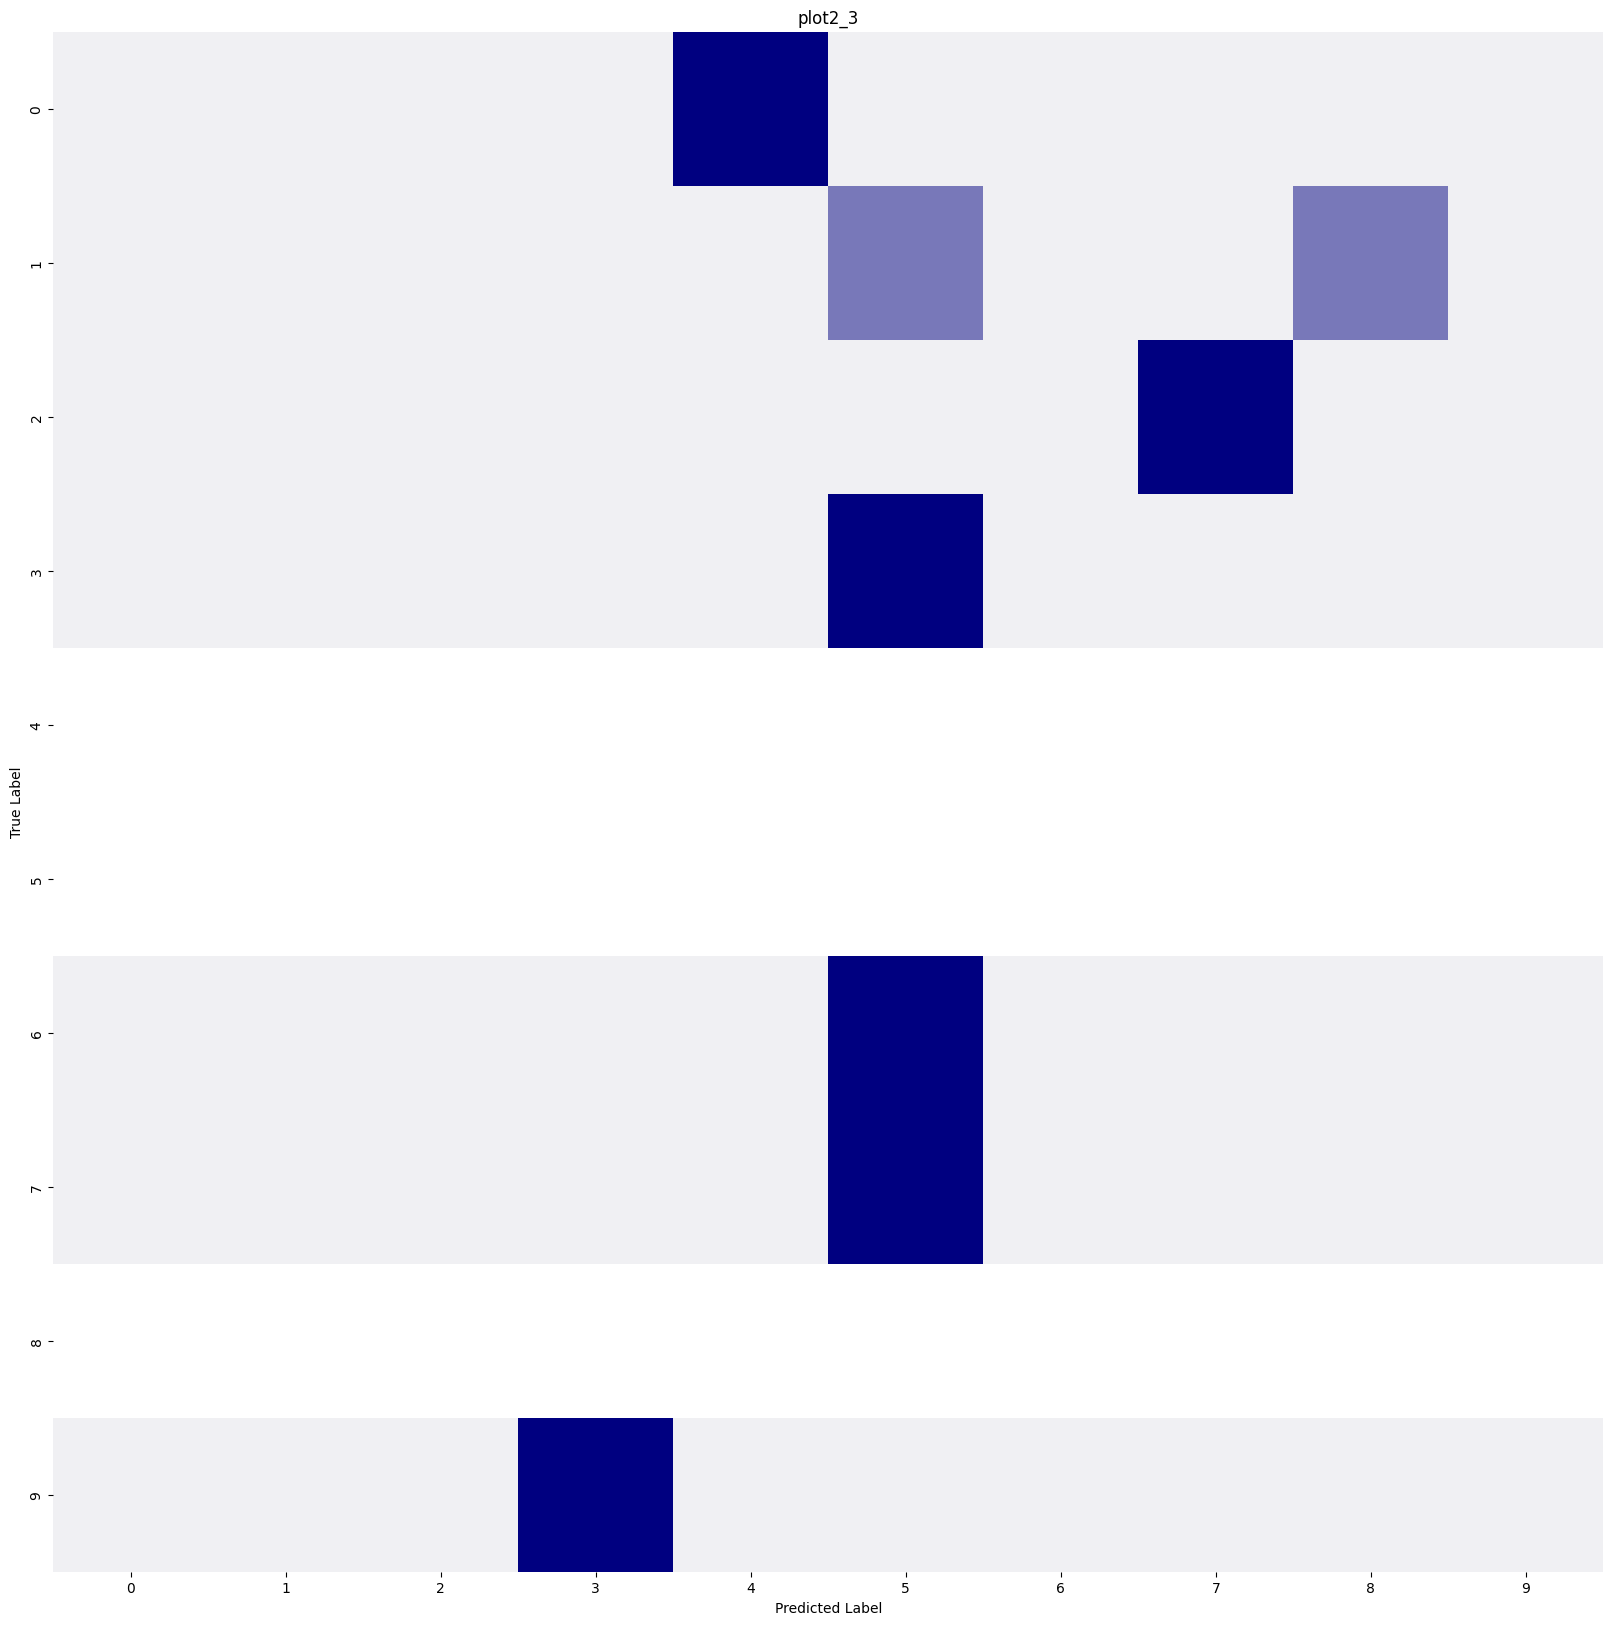

<Figure size 1400x600 with 0 Axes>

In [ ]:
phase2_3()